In [3]:
from datasets import Dataset
from gpn.data import GenomeMSA
from gpn.msa.inference import run_inference
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from scipy.spatial.distance import cdist
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
genome_msa = GenomeMSA("../../results/msa/multiz100way/89/all.zarr")

Loading MSA...
Loading MSA... Done


In [31]:
from gpn.data import Tokenizer, ReverseComplementer
import gpn.model
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoModel, AutoModelForMaskedLM


class VEPEmbedding(torch.nn.Module):
    def __init__(self, model_path, embedding_mean=None, embedding_std=None):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_path)
        if embedding_mean is not None and embedding_std is not None:
            self.register_buffer("embedding_mean", torch.tensor(embedding_mean))
            self.register_buffer("embedding_std", torch.tensor(embedding_std))
        else:
            self.embedding_mean = None

    def get_embedding(self, input_ids, aux_features, exclude_pos=None):
        embedding = self.model(
            input_ids=input_ids, aux_features=aux_features,
        ).last_hidden_state
        
        if exclude_pos is not None:
            embedding = torch.cat((embedding[:, :exclude_pos], embedding[:, exclude_pos+1:]), dim=1)

        # chosing specific layer
        #hidden_states = self.model(
        #    input_ids=input_ids, aux_features=aux_features,
        #    output_hidden_states=True,
        #).hidden_states # note 0 is the encoder, so last layer is 12, not 11
        #embedding = torch.cat((hidden_states[-1], hidden_states[-2]), dim=-1)  
            
        if self.embedding_mean is not None:
            embedding = (embedding - self.embedding_mean) / self.embedding_std
        
        # this usually on
        #embedding = embedding.reshape(len(input_ids), -1)
        
        return embedding
    
    def get_scores(self, input_ids_ref, aux_features_ref, input_ids_alt, aux_features_alt, exclude_pos=None):
        embedding_ref = self.get_embedding(input_ids_ref, aux_features_ref, exclude_pos=exclude_pos)
        embedding_alt = self.get_embedding(input_ids_alt, aux_features_alt, exclude_pos=exclude_pos)
        return torch.stack((embedding_ref, embedding_alt), dim=1)
        return (
            F.pairwise_distance(embedding_ref, embedding_alt),
            (embedding_ref * embedding_alt).sum(dim=1),  # dot product
            F.cosine_similarity(embedding_ref, embedding_alt),
        )

    def forward(
        self,
        input_ids_ref_fwd=None,
        aux_features_ref_fwd=None,
        input_ids_alt_fwd=None,
        aux_features_alt_fwd=None,
        input_ids_ref_rev=None,
        aux_features_ref_rev=None,
        input_ids_alt_rev=None,
        aux_features_alt_rev=None,
    ):
        W = input_ids_ref_fwd.shape[1]

        return torch.cat((
            self.get_scores(input_ids_ref_fwd, aux_features_ref_fwd, input_ids_alt_fwd, aux_features_alt_fwd),
            self.get_scores(input_ids_ref_rev, aux_features_ref_rev, input_ids_alt_rev, aux_features_alt_rev),
        ), dim=1)
        fwd1, fwd2, fwd3 = self.get_scores(
            input_ids_ref_fwd, aux_features_ref_fwd, input_ids_alt_fwd, aux_features_alt_fwd,
            #exclude_pos=W//2,
        )
        rev1, rev2, rev3 = self.get_scores(
            input_ids_ref_rev, aux_features_ref_rev, input_ids_alt_rev, aux_features_alt_rev,
            #exclude_pos=(W//2) - 1,
        )
        return torch.stack((
            (fwd1 + rev1) / 2,
            (fwd2 + rev2) / 2,
            (fwd3 + rev3) / 2,
        
        ), dim=1)


class VEPEmbeddingInference(object):
    def __init__(self, model_path, genome_msa, window_size):
        self.model = VEPEmbedding(model_path)#, embedding_mean=embedding_mean, embedding_std=embedding_std)
        self.genome_msa = genome_msa
        self.window_size = window_size
        self.tokenizer = Tokenizer()
        self.reverse_complementer = ReverseComplementer()

    def tokenize_function(self, V):
        # we convert from 1-based coordinate (standard in VCF) to
        # 0-based, to use with GenomeMSA
        chrom = np.array(V["chrom"])
        pos = np.array(V["pos"]) - 1
        start = pos - self.window_size // 2
        end = pos + self.window_size // 2
        
        msa_fwd, msa_rev = self.genome_msa.get_msa_batch_fwd_rev(
            chrom,
            start,
            end,
            tokenize=True,
        )
        pos_fwd = self.window_size // 2
        pos_rev = pos_fwd - 1 if self.window_size % 2 == 0 else pos_fwd

        ref_fwd = np.array(
            [np.frombuffer(x.encode("ascii"), dtype="S1") for x in V["ref"]]
        )
        alt_fwd = np.array(
            [np.frombuffer(x.encode("ascii"), dtype="S1") for x in V["alt"]]
        )
        ref_rev = self.reverse_complementer(ref_fwd)
        alt_rev = self.reverse_complementer(alt_fwd)

        def prepare_output(msa, pos, ref, alt):
            ref, alt = self.tokenizer(ref.flatten()), self.tokenizer(alt.flatten())
            input_ids, aux_features = msa[:, :, 0], msa[:, :, 1:]
            assert (
                input_ids[:, pos] == ref
            ).all(), f"{input_ids[:, pos].tolist()}, {ref.tolist()}"
            input_ids_alt = input_ids.copy()
            input_ids_alt[:, pos] = alt
            input_ids = input_ids.astype(np.int64)
            input_ids_alt = input_ids_alt.astype(np.int64)
            return input_ids, aux_features, input_ids_alt, aux_features

        res = {}
        (
            res["input_ids_ref_fwd"],
            res["aux_features_ref_fwd"],
            res["input_ids_alt_fwd"],
            res["aux_features_alt_fwd"],
        ) = prepare_output(msa_fwd, pos_fwd, ref_fwd, alt_fwd)
        (
            res["input_ids_ref_rev"],
            res["aux_features_ref_rev"],
            res["input_ids_alt_rev"],
            res["aux_features_alt_rev"],
        ) = prepare_output(msa_rev, pos_rev, ref_rev, alt_rev)
        return res

    def postprocess(self, pred):
        return pred
        #return pd.DataFrame(pred, columns=["euclidean_distance", "inner_product", "cosine_similarity"])
        #return pd.DataFrame(pred, columns=["score"])


def score_vep(V2):
    dataset = Dataset.from_pandas(V2[cols])
    inference = VEPEmbeddingInference("songlab/gpn-msa-sapiens", genome_msa, 128)
    pred = run_inference(
        dataset,
        inference,
        per_device_batch_size=256,
        dataloader_num_workers=8,
    )
    return pred


def add_scores(V2):
    V2.loc[:, ["euclidean_distance", "inner_product", "cosine_similarity"]] = score_vep(V2)
    V2.euclidean_distance *= -1
    V2.cosine_similarity -= V2.cosine_similarity.max()
    V2.inner_product -= V2.inner_product.max()
    return V2

In [11]:
models = [
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    "CADD.RawScore",
    "phyloP",
]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
}

V = pd.read_parquet("../../results/causaldb/test.parquet")
d = Path(f"../../results/preds/results/causaldb")
for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,pip,GPN-MSA,CADD,phyloP
0,1,727242,G,A,4.651720e-12,-1.317049,-0.413109,-0.655
1,1,758351,A,G,5.534810e-11,-0.050360,-0.296760,-0.289
2,1,758443,G,C,3.978040e-12,-0.226570,-1.064142,-0.252
3,1,770988,A,G,8.349990e-13,-0.988294,-0.170610,-0.291
4,1,796338,T,C,7.095540e-10,1.562877,0.140019,0.372
...,...,...,...,...,...,...,...,...
757818,22,50783303,T,C,0.000000e+00,-1.394941,-0.715689,-0.049
757819,22,50784338,G,A,2.306390e-03,-0.965638,-0.267661,-0.450
757820,22,50791228,G,A,0.000000e+00,1.697440,0.163494,2.096
757821,22,50791377,T,C,0.000000e+00,-0.309580,-0.211272,-0.286


In [12]:
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()

GPN-MSA


In [13]:
not_na = ~V[models].isna().any(axis=1)
not_na.mean()

0.9860983369467541

In [14]:
V = V[not_na]
V.shape

(747288, 8)

In [15]:
V2 = V.copy()
V2.loc[V2.pip > 0.99, "Likely causal"] = True
V2.loc[V2.pip < 0.01, "Likely causal"] = False
V2 = V2.dropna(subset="Likely causal")
V2["Likely causal"] = V2["Likely causal"].astype(bool)
V2["Likely causal"].value_counts()

Likely causal
False    734816
True       7841
Name: count, dtype: int64

In [16]:
results = []
for m in models:
    results.append([
        m,
        roc_auc_score(V2["Likely causal"], -V2[m]),
        average_precision_score(V2["Likely causal"], -V2[m]),
    ])
results = pd.DataFrame(results, columns=["Model", "AUROC", "AUPRC"])
results

,Model,AUROC,AUPRC
0,GPN-MSA,0.552169,0.019186
1,CADD,0.520590,0.023708
2,phyloP,0.559628,0.018544


<Axes: xlabel='AUPRC', ylabel='Model'>

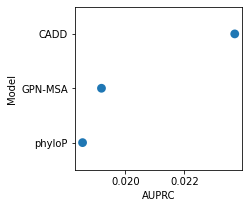

In [17]:
plt.figure(figsize=(3,3))
sns.pointplot(
    data=results.sort_values("AUPRC", ascending=False),
    y="Model",
    x="AUPRC",
    join=False,
)